In [146]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from scipy.stats import permutation_test, false_discovery_control, spearmanr
import pybedtools

from warnings import filterwarnings
filterwarnings("ignore", category=pd.errors.DtypeWarning)
filterwarnings("ignore", category=pd.errors.SettingWithCopyWarning)

#set up paths
#=========================
workdir = '/home/AD/rkgadde/L1IP'
annotation = f'{workdir}/hg38_data/annotations/gencode.v46.basic.annotation.sorted.genes.gff3'
celltypes = f'{workdir}/celltypes.txt'

genedir = f'{workdir}/gene_data'
figdir = f'{workdir}/results/CZI/plots'

# Load in data

In [115]:
#process l1
me_type = 'L1'
abs_file = f'{workdir}/mC_data/CZI/type/vars/all_{me_type}_abs.tsv'
ins_file = f'{workdir}/mC_data/CZI/type/vars/all_{me_type}_ins.tsv'
abs_df = pd.read_csv(abs_file, sep='\t', usecols=[0,1,2,3,4,5,6,7,8], names=['chrom','start','end','id', 'length', 'strand', 'class', 'het', 'hom'])[1:]
abs_df['me_type'] = 'absence'
ins_df = pd.read_csv(ins_file, sep='\t', usecols=[0,1,2,3,4,5,6,7,8],  names=['chrom','start','end','id', 'length', 'strand', 'class', 'het', 'hom'])[1:]
ins_df['me_type'] = 'insertion'
l1_df = pd.concat([abs_df, ins_df])
l1_df['class'] = 'l1'

#process alu
me_type = 'Alu'
abs_file = f'{workdir}/mC_data/CZI/type/vars/all_{me_type}_abs.tsv'
ins_file = f'{workdir}/mC_data/CZI/type/vars/all_{me_type}_ins.tsv'
abs_df = pd.read_csv(abs_file, sep='\t', usecols=[0,1,2,3,4,5,6,7,8], names=['chrom','start','end','id', 'length', 'strand', 'class', 'het', 'hom'])[1:]
abs_df['me_type'] = 'absence'
ins_df = pd.read_csv(ins_file, sep='\t', usecols=[0,1,2,3,4,5,6, 7,8],  names=['chrom','start','end','id', 'length', 'strand', 'class', 'het', 'hom'])[1:]
ins_df['me_type'] = 'insertion'
alu_df = pd.concat([abs_df, ins_df])
alu_df['class'] = 'alu'

#combine + add labels
#===============================
comb_df = pd.concat([l1_df, alu_df])
comb_df['start'] = comb_df['start'].astype(int)
comb_df['end'] = comb_df['end'].astype(int)
comb_df['length'] = comb_df['end'] - comb_df['start']
comb_df['het'] = comb_df['het'].fillna('NaN').astype(str)
comb_df['hom'] = comb_df['hom'].fillna('NaN').astype(str)
comb_df.reset_index(drop=True, inplace=True)
het_bool = np.asarray([True if 'NaN' not in i else False for i in comb_df['het']])
hom_bool = np.asarray([True if 'NaN' not in i else False for i in comb_df['hom']])
het_count = np.asarray([len(i.split(',')) for i in comb_df['het']])
hom_count = np.asarray([len(i.split(',')) for i in comb_df['hom']])
ratio = het_count/hom_count
#set to NaN and inf
ratio[(het_bool == False) & (hom_bool==False)] = np.nan
ratio[(het_bool == True) & (hom_bool==False)] = np.inf
ratio[(het_bool == False) & (hom_bool==True)] = -1*np.inf
comb_df['het_over_hom'] = ratio
# label as majority het or hom, if >2x
genotype = np.empty(len(comb_df)).astype(str)
genotype[ratio >= 2] = 'het'
genotype[ratio <= 0.5] = 'hom'
genotype[(ratio <= 2) & (ratio >= 0.5)] = 'mixed'
genotype[np.isnan(ratio)] = 'NaN'
comb_df['genotype'] = genotype
#label as truncated or full length
trunc = np.empty(len(comb_df), dtype=object)
l1_mask = comb_df['class'] == 'l1'
trunc[l1_mask & (comb_df['length'] > 5500)] = 'full_length'
trunc[l1_mask & (comb_df['length'] <= 5500)] = 'truncated'
alu_mask = comb_df['class'] == 'alu'
trunc[alu_mask & (comb_df['length'] > 280)] = 'full_length'
trunc[alu_mask & (comb_df['length'] <= 280)] = 'truncated'
comb_df['insertion_category'] = trunc

#bedconvert and load annotations
l1_df = comb_df[comb_df['class']=='l1'].copy()
alu_df = comb_df[comb_df['class']=='alu'].copy()
alu_bt = pybedtools.BedTool.from_dataframe(alu_df)
l1_bt = pybedtools.BedTool.from_dataframe(l1_df)
cgi_df = pd.read_csv('/cndd3/dburrows/DATA/annotations/gencode/gencode.v37.CGI.hg38.jofan.bed', sep='\t',header=None)
all_df = pd.read_csv('/cndd3/dburrows/DATA/annotations/gencode/red.bed', sep='\t',header=None)
cgi_bt = pybedtools.BedTool.from_dataframe(cgi_df)
all_bt = pybedtools.BedTool.from_dataframe(all_df)

# plot basic statistics of MEs

In [38]:
curr['het'][curr['het'] == 'NaN']

2       NaN
3       NaN
4       NaN
6       NaN
8       NaN
       ... 
4886    NaN
4903    NaN
4909    NaN
4995    NaN
4999    NaN
Name: het, Length: 606, dtype: object

In [48]:
curr[(curr['het'] == 'NaN') & (curr['hom']  == 'NaN')]

,chrom,start,end,id,length,strand,class,het,hom,me_type,het_over_hom,genotype,insertion_category
15,chr11,16565614,16565752,CZI_abs_1563,138,+,l1,NaN,NaN,absence,NaN,NaN,truncated
40,chr19,44546245,44546890,CZI_abs_1595,645,-,l1,NaN,NaN,absence,NaN,NaN,truncated
41,chr2,4733719,4739766,CZI_abs_1597,6047,+,l1,NaN,NaN,absence,NaN,NaN,full_length
47,chr2,195187106,195187361,CZI_abs_1609,255,+,l1,NaN,NaN,absence,NaN,NaN,truncated
56,chr3,107094783,107094942,CZI_abs_1620,159,-,l1,NaN,NaN,absence,NaN,NaN,truncated
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3918,chr4,66240879,66240898,CZI_ins_3134,19,+,alu,NaN,NaN,insertion,NaN,NaN,truncated
4189,chr5,115404024,115404039,CZI_ins_3426,15,-,alu,NaN,NaN,insertion,NaN,NaN,truncated
4207,chr5,131517547,131517565,CZI_ins_3444,18,+,alu,NaN,NaN,insertion,NaN,NaN,truncated
4652,chr7,128289264,128289277,CZI_ins_3939,13,-,alu,NaN,NaN,insertion,NaN,NaN,truncated


In [69]:
#plot number of intersections by genotype, insertion type, length, region
#combine together intersected labelled data
#===========================================
curr = comb_df
#remove any that arent labelled as het or hom
index = curr[(curr['het'] == 'NaN') & (curr['hom']  == 'NaN')].index
curr.drop(index=index, inplace=True)
curr.reset_index(drop=True, inplace=True)

new_df = pd.DataFrame()
for i in range(len(curr)):
    if curr['het'][i] != 'NaN':
        rep = pd.concat([pd.DataFrame(curr.loc[i]).T] * len(curr['het'][i].split(',')), ignore_index=True)
        rep['sample'] = curr['het'][i].split(',')
        rep['genotype_sample'] = np.repeat('het', len(rep))
        new_df = pd.concat([new_df, rep])

    if curr['hom'][i] != 'NaN':
        rep = pd.concat([pd.DataFrame(curr.loc[i]).T] * len(curr['hom'][i].split(',')), ignore_index=True)
        rep['sample'] = curr['hom'][i].split(',')
        rep['genotype_sample'] = np.repeat('hom', len(rep))
        new_df = pd.concat([new_df, rep])

comb_int_df = new_df

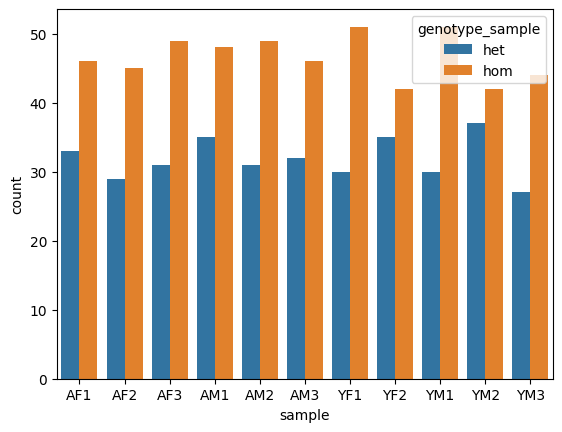

In [77]:
#plot 
#l1 absences
l1_samp_df = comb_int_df[comb_int_df['class']=='l1']
plot_df = pd.DataFrame(l1_samp_df.groupby(['sample', 'me_type', 'genotype_sample']).count()['chrom'])
plot_df.rename(columns={'chrom':'count'}, inplace=True)
plot_df.reset_index(inplace=True)
sns.barplot(data=plot_df[plot_df['me_type']=='absence'], x ='sample', y = 'count', hue = 'genotype_sample')
plt.show()

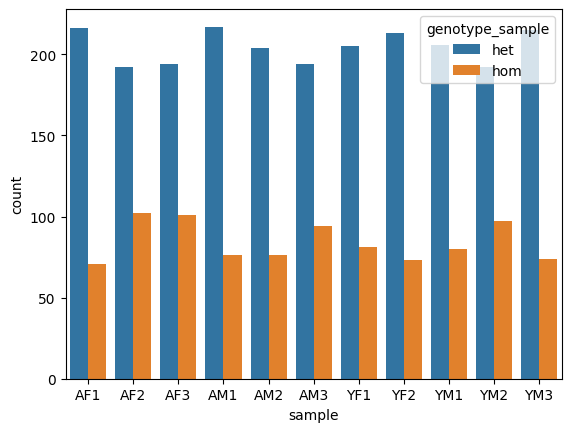

In [74]:
#plot l1
#l1 insertions
l1_samp_df = comb_int_df[comb_int_df['class']=='l1']
plot_df = pd.DataFrame(l1_samp_df.groupby(['sample', 'me_type', 'genotype_sample']).count()['chrom'])
plot_df.rename(columns={'chrom':'count'}, inplace=True)
plot_df.reset_index(inplace=True)
sns.barplot(data=plot_df[plot_df['me_type']=='insertion'], x ='sample', y = 'count', hue = 'genotype_sample')
plt.show()

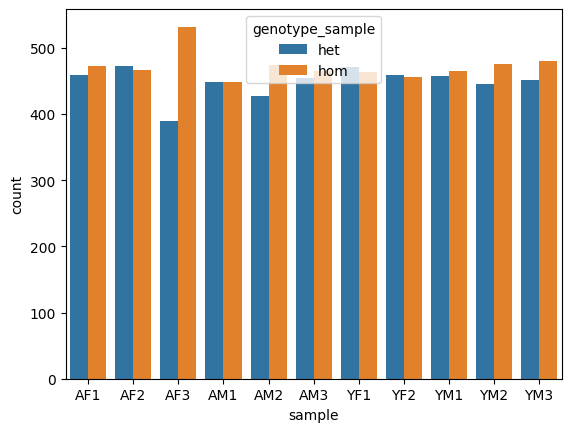

In [75]:
#plot alu
#alu absences
alu_samp_df = comb_int_df[comb_int_df['class']=='alu']
plot_df = pd.DataFrame(alu_samp_df.groupby(['sample', 'me_type', 'genotype_sample']).count()['chrom'])
plot_df.rename(columns={'chrom':'count'}, inplace=True)
plot_df.reset_index(inplace=True)
sns.barplot(data=plot_df[plot_df['me_type']=='absence'], x ='sample', y = 'count', hue = 'genotype_sample')
plt.show()

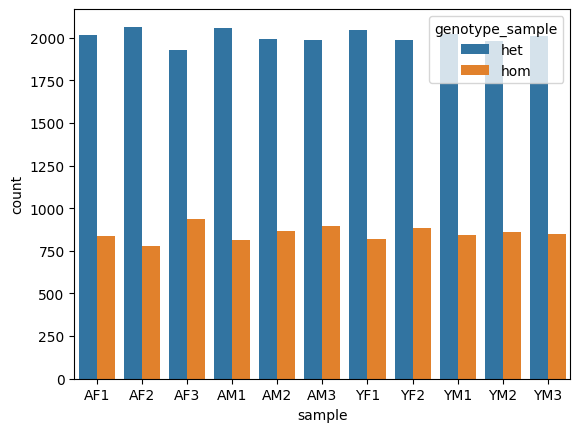

In [76]:
#plot alu
#alu insertions
alu_samp_df = comb_int_df[comb_int_df['class']=='alu']
plot_df = pd.DataFrame(alu_samp_df.groupby(['sample', 'me_type', 'genotype_sample']).count()['chrom'])
plot_df.rename(columns={'chrom':'count'}, inplace=True)
plot_df.reset_index(inplace=True)
sns.barplot(data=plot_df[plot_df['me_type']=='insertion'], x ='sample', y = 'count', hue = 'genotype_sample')
plt.show()

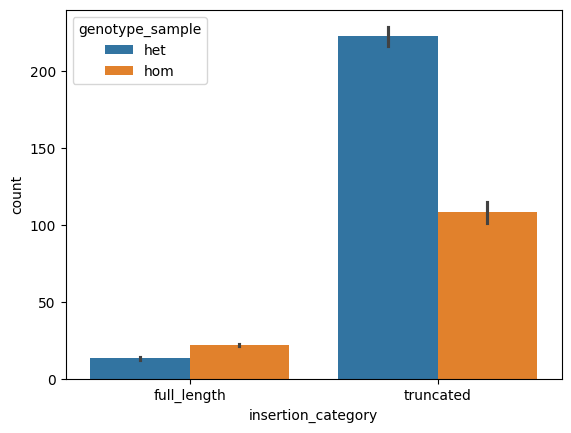

In [85]:
#what proportion of hets vs homs are truncated vs full-length
l1_samp_df = comb_int_df[comb_int_df['class']=='l1']
plot_df = pd.DataFrame(l1_samp_df.groupby(['sample', 'genotype_sample', 'insertion_category']).count()['chrom'])
plot_df.rename(columns={'chrom':'count'}, inplace=True)
plot_df.reset_index(inplace=True)
sns.barplot(data=plot_df, x ='insertion_category', y = 'count', hue = 'genotype_sample')
plt.show()

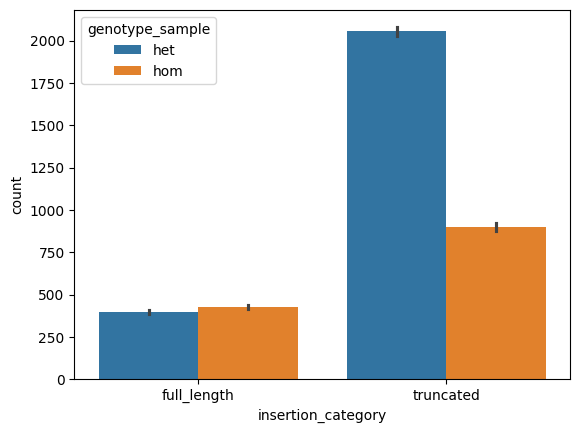

In [86]:
#what proportion of hets vs homs are truncated vs full-length

l1_samp_df = comb_int_df[comb_int_df['class']=='alu']
plot_df = pd.DataFrame(l1_samp_df.groupby(['sample', 'genotype_sample', 'insertion_category']).count()['chrom'])
plot_df.rename(columns={'chrom':'count'}, inplace=True)
plot_df.reset_index(inplace=True)
sns.barplot(data=plot_df, x ='insertion_category', y = 'count', hue = 'genotype_sample')
plt.show()

# Compute intersection

In [88]:
#compute intersection
l1_cgi = l1_bt.intersect(cgi_bt, f=0.3, wo=True) 
alu_cgi = alu_bt.intersect(cgi_bt, f=0.3, wo=True) 
alu_all = alu_bt.intersect(all_bt, f=0.3, wo=True) 
l1_all = all_bt.intersect(l1_bt, f=0.3, wo=True) 

l1_cgi_df = l1_cgi.to_dataframe(disable_auto_names=True, header=None)
l1_cgi_df.rename(columns={16: 'region', 9: 'me_type', 11: 'genotype', 12: 'insertion_category', 7: 'het', 8: 'hom', 4: 'length'}, inplace=True)
alu_cgi_df = alu_cgi.to_dataframe(disable_auto_names=True, header=None)
alu_cgi_df.rename(columns={16: 'region', 9: 'me_type', 11: 'genotype', 12: 'insertion_category', 7: 'het', 8: 'hom', 4: 'length'}, inplace=True)
alu_all_df = alu_all.to_dataframe(disable_auto_names=True, header=None)
alu_all_df.rename(columns={16: 'region', 9: 'me_type', 11: 'genotype', 12: 'insertion_category', 7: 'het', 8: 'hom', 4: 'length'}, inplace=True)
l1_all_df = l1_all.to_dataframe(disable_auto_names=True, header=None)
l1_all_df.rename(columns={3: 'region', 15: 'me_type', 17: 'genotype', 18: 'insertion_category', 13: 'het', 14: 'hom', 10: 'length'}, inplace=True)

In [321]:
#plot number of intersections by genotype, insertion type, length, region

#combine together intersected labelled data
#===========================================
l1_out = pd.concat([l1_cgi_df[['me_type', 'region', 'het', 'hom', 'genotype', 'length']], 
                    l1_all_df[['me_type', 'region', 'het', 'hom', 'genotype', 'length']]])

alu_out = pd.concat([alu_cgi_df[['me_type', 'region', 'het', 'hom', 'genotype', 'length']], 
                    alu_all_df[['me_type', 'region', 'het', 'hom', 'genotype', 'length']]])
l1_out['class'] = 'l1'
alu_out['class'] = 'alu'
comb_df = pd.concat([l1_out, alu_out])

curr = comb_df.copy()
index = curr[(curr['het'].isna()) & (curr['hom'].isna())].index
curr.reset_index(drop=True, inplace=True)

new_df = pd.DataFrame()
for i in range(len(curr)):
    if curr['het'][i] != '.':
        rep = pd.concat([pd.DataFrame(curr.loc[i]).T] * len(curr['het'][i].split(',')), ignore_index=True)
        rep['sample'] = curr['het'][i].split(',')
        rep['genotype_sample'] = np.repeat('het', len(rep))
        new_df = pd.concat([new_df, rep])

    if curr['hom'][i] != '.':
        rep = pd.concat([pd.DataFrame(curr.loc[i]).T] * len(curr['hom'][i].split(',')), ignore_index=True)
        rep['sample'] = curr['hom'][i].split(',')
        rep['genotype_sample'] = np.repeat('hom', len(rep))
        new_df = pd.concat([new_df, rep])

comb_int_df = new_df

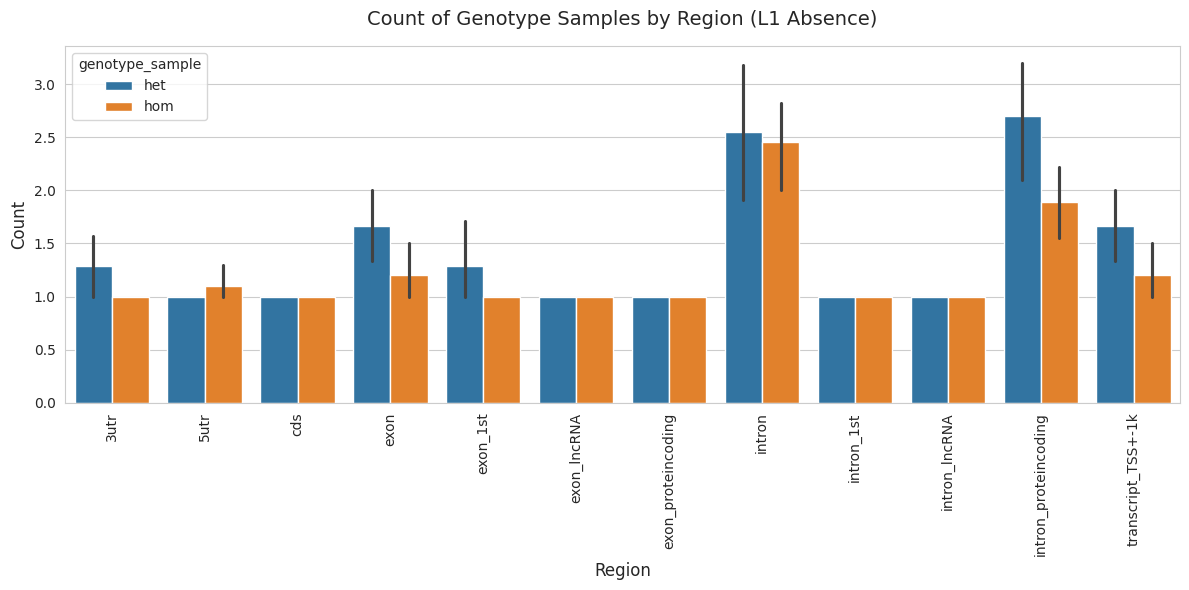

In [293]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot DataFrame (from your example)
plot_df = pd.DataFrame(comb_int_df.groupby(['region', 'me_type', 'genotype_sample', 'sample', 'class']).count()['het'])
plot_df.rename(columns={'het': 'count'}, inplace=True)
plot_df.reset_index(inplace=True)

# Set plot size and style
plt.figure(figsize=(12, 6))  # Increase plot size (width, height)
sns.set_style("whitegrid")  # Use a clean aesthetic style

# Create the barplot
sns.barplot(
    data=plot_df[(plot_df['me_type'] == 'absence') & (plot_df['class'] == 'l1')],
    x='region', y='count', hue='genotype_sample'
)

# Rotate x-axis labels
plt.xticks(rotation=90)

# Add a title and axis labels for better visualization
plt.title('Count of Genotype Samples by Region (L1 Absence)', fontsize=14, pad=15)
plt.xlabel('Region', fontsize=12)
plt.ylabel('Count', fontsize=12)

# Display the plot
plt.tight_layout()  # Ensure everything fits nicely in the figure
plt.show()


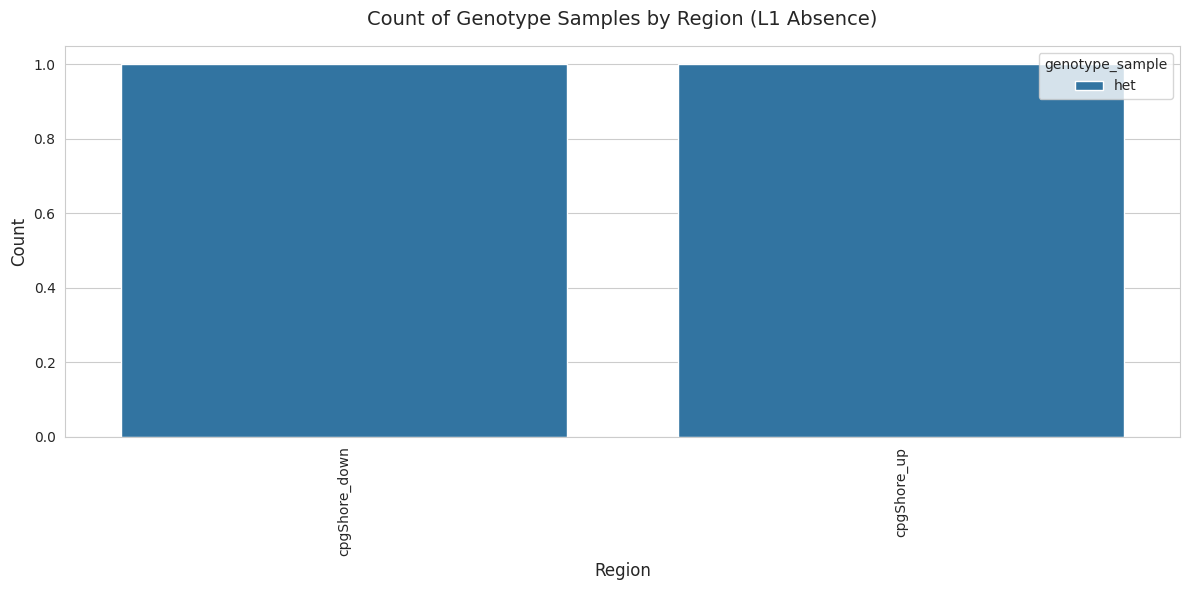

In [295]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot DataFrame (from your example)
plot_df = pd.DataFrame(comb_int_df.groupby(['region', 'me_type', 'genotype_sample', 'sample', 'class']).count()['het'])
plot_df.rename(columns={'het': 'count'}, inplace=True)
plot_df.reset_index(inplace=True)

# Set plot size and style
plt.figure(figsize=(12, 6))  # Increase plot size (width, height)
sns.set_style("whitegrid")  # Use a clean aesthetic style

# Create the barplot
sns.barplot(
    data=plot_df[(plot_df['me_type'] == 'insertion') & (plot_df['class'] == 'l1')],
    x='region', y='count', hue='genotype_sample'
)

# Rotate x-axis labels
plt.xticks(rotation=90)

# Add a title and axis labels for better visualization
plt.title('Count of Genotype Samples by Region (L1 Absence)', fontsize=14, pad=15)
plt.xlabel('Region', fontsize=12)
plt.ylabel('Count', fontsize=12)

# Display the plot
plt.tight_layout()  # Ensure everything fits nicely in the figure
plt.show()


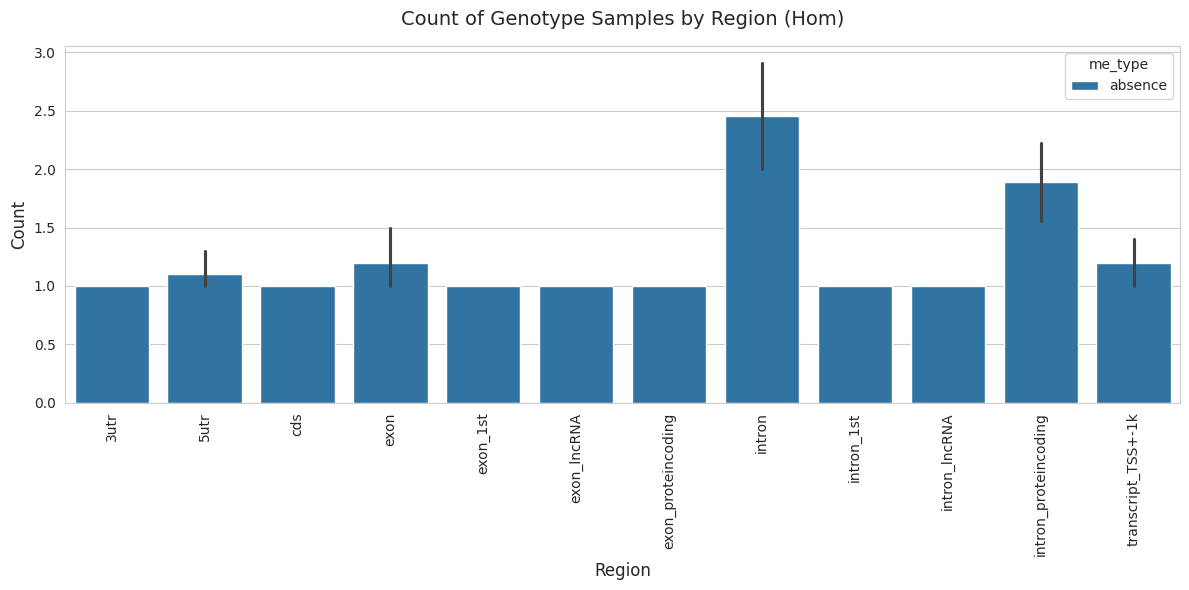

In [302]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot DataFrame (from your example)
plot_df = pd.DataFrame(comb_int_df.groupby(['region', 'me_type', 'genotype_sample', 'sample', 'class']).count()['het'])
plot_df.rename(columns={'het': 'count'}, inplace=True)
plot_df.reset_index(inplace=True)

# Set plot size and style
plt.figure(figsize=(12, 6))  # Increase plot size (width, height)
sns.set_style("whitegrid")  # Use a clean aesthetic style

# Create the barplot
sns.barplot(
    data=plot_df[(plot_df['genotype_sample'] == 'hom') & (plot_df['class'] == 'l1')],
    x='region', y='count', hue='me_type'
)

# Rotate x-axis labels
plt.xticks(rotation=90)

# Add a title and axis labels for better visualization
plt.title('Count of Genotype Samples by Region (Hom)', fontsize=14, pad=15)
plt.xlabel('Region', fontsize=12)
plt.ylabel('Count', fontsize=12)

# Display the plot
plt.tight_layout()  # Ensure everything fits nicely in the figure
plt.show()

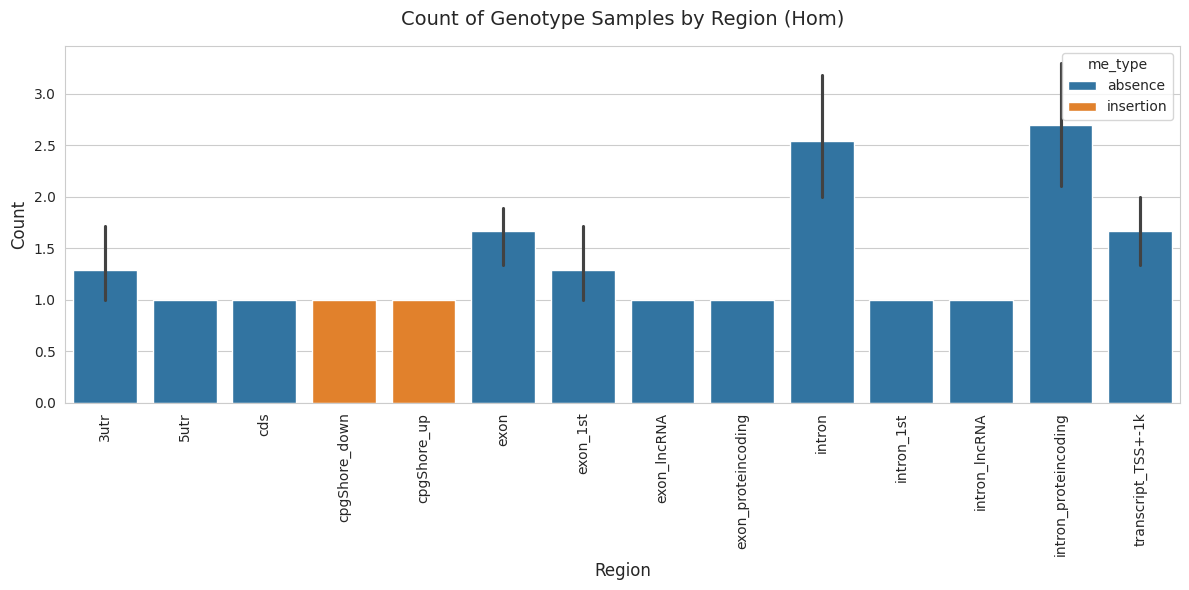

In [303]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot DataFrame (from your example)
plot_df = pd.DataFrame(comb_int_df.groupby(['region', 'me_type', 'genotype_sample', 'sample', 'class']).count()['het'])
plot_df.rename(columns={'het': 'count'}, inplace=True)
plot_df.reset_index(inplace=True)

# Set plot size and style
plt.figure(figsize=(12, 6))  # Increase plot size (width, height)
sns.set_style("whitegrid")  # Use a clean aesthetic style

# Create the barplot
sns.barplot(
    data=plot_df[(plot_df['genotype_sample'] == 'het') & (plot_df['class'] == 'l1')],
    x='region', y='count', hue='me_type'
)

# Rotate x-axis labels
plt.xticks(rotation=90)

# Add a title and axis labels for better visualization
plt.title('Count of Genotype Samples by Region (Hom)', fontsize=14, pad=15)
plt.xlabel('Region', fontsize=12)
plt.ylabel('Count', fontsize=12)
# Display the plot
plt.tight_layout()  # Ensure everything fits nicely in the figure
plt.show()

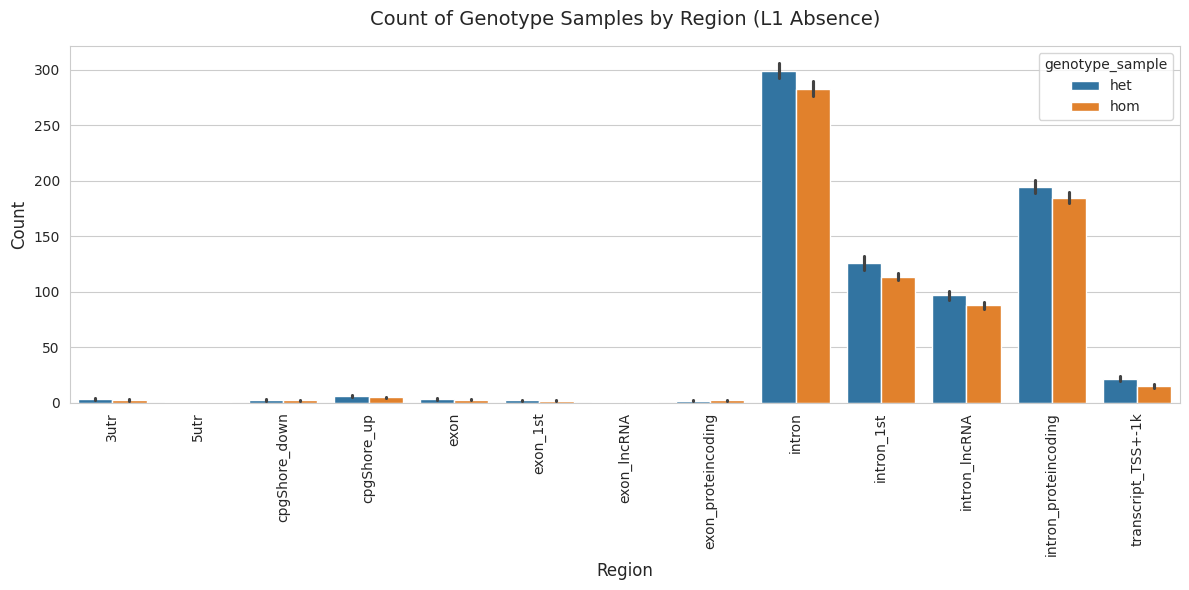

In [296]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot DataFrame (from your example)
plot_df = pd.DataFrame(comb_int_df.groupby(['region', 'me_type', 'genotype_sample', 'sample', 'class']).count()['het'])
plot_df.rename(columns={'het': 'count'}, inplace=True)
plot_df.reset_index(inplace=True)

# Set plot size and style
plt.figure(figsize=(12, 6))  # Increase plot size (width, height)
sns.set_style("whitegrid")  # Use a clean aesthetic style

# Create the barplot
sns.barplot(
    data=plot_df[(plot_df['me_type'] == 'absence') & (plot_df['class'] == 'alu')],
    x='region', y='count', hue='genotype_sample'
)

# Rotate x-axis labels
plt.xticks(rotation=90)

# Add a title and axis labels for better visualization
plt.title('Count of Genotype Samples by Region (L1 Absence)', fontsize=14, pad=15)
plt.xlabel('Region', fontsize=12)
plt.ylabel('Count', fontsize=12)

# Display the plot
plt.tight_layout()  # Ensure everything fits nicely in the figure
plt.show()


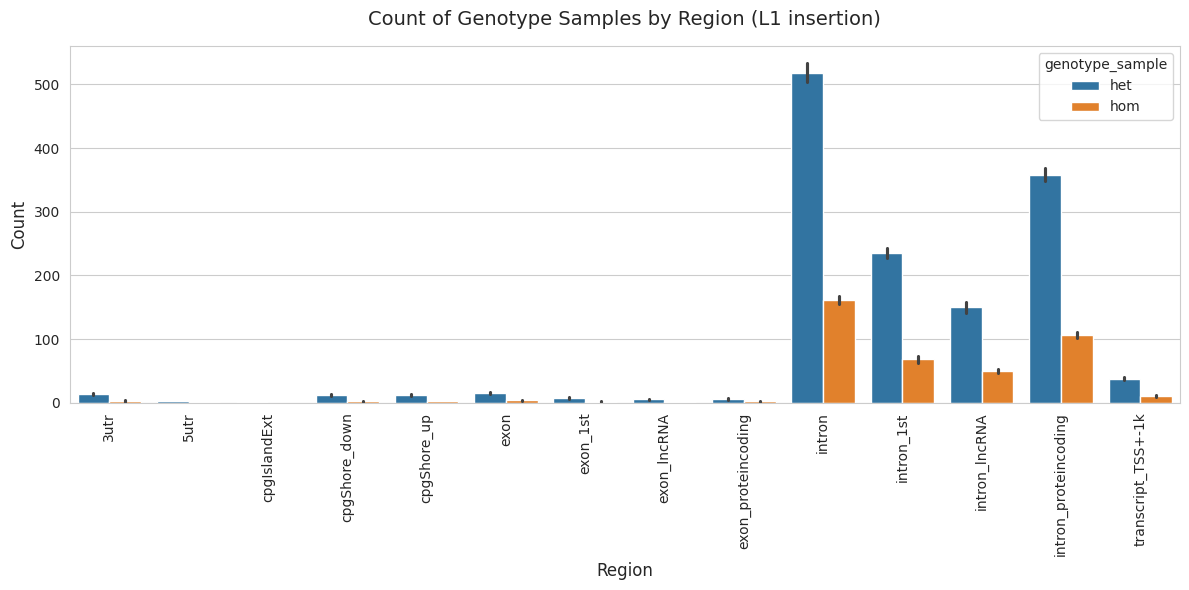

In [298]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot DataFrame (from your example)
plot_df = pd.DataFrame(comb_int_df.groupby(['region', 'me_type', 'genotype_sample', 'sample', 'class']).count()['het'])
plot_df.rename(columns={'het': 'count'}, inplace=True)
plot_df.reset_index(inplace=True)

# Set plot size and style
plt.figure(figsize=(12, 6))  # Increase plot size (width, height)
sns.set_style("whitegrid")  # Use a clean aesthetic style

# Create the barplot
sns.barplot(
    data=plot_df[(plot_df['me_type'] == 'insertion') & (plot_df['class'] == 'alu')],
    x='region', y='count', hue='genotype_sample'
)

# Rotate x-axis labels
plt.xticks(rotation=90)

# Add a title and axis labels for better visualization
plt.title('Count of Genotype Samples by Region (L1 insertion)', fontsize=14, pad=15)
plt.xlabel('Region', fontsize=12)
plt.ylabel('Count', fontsize=12)

# Display the plot
plt.tight_layout()  # Ensure everything fits nicely in the figure
plt.show()


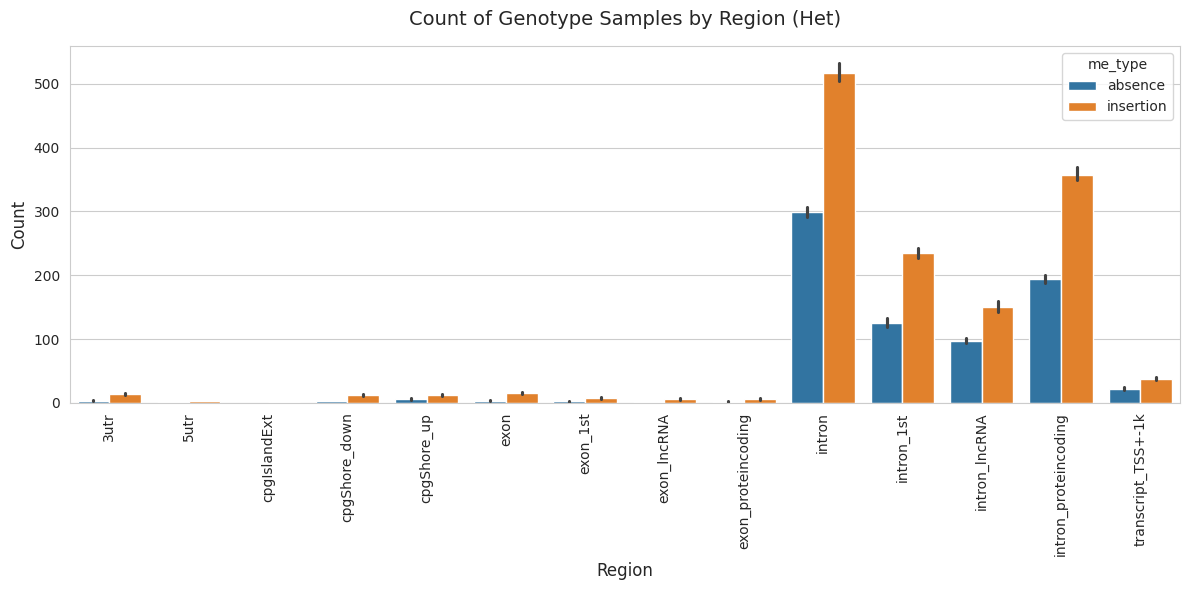

In [300]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot DataFrame (from your example)
plot_df = pd.DataFrame(comb_int_df.groupby(['region', 'me_type', 'genotype_sample', 'sample', 'class']).count()['het'])
plot_df.rename(columns={'het': 'count'}, inplace=True)
plot_df.reset_index(inplace=True)

# Set plot size and style
plt.figure(figsize=(12, 6))  # Increase plot size (width, height)
sns.set_style("whitegrid")  # Use a clean aesthetic style

# Create the barplot
sns.barplot(
    data=plot_df[(plot_df['genotype_sample'] == 'het') & (plot_df['class'] == 'alu')],
    x='region', y='count', hue='me_type'
)

# Rotate x-axis labels
plt.xticks(rotation=90)

# Add a title and axis labels for better visualization
plt.title('Count of Genotype Samples by Region (Het)', fontsize=14, pad=15)
plt.xlabel('Region', fontsize=12)
plt.ylabel('Count', fontsize=12)

# Display the plot
plt.tight_layout()  # Ensure everything fits nicely in the figure
plt.show()


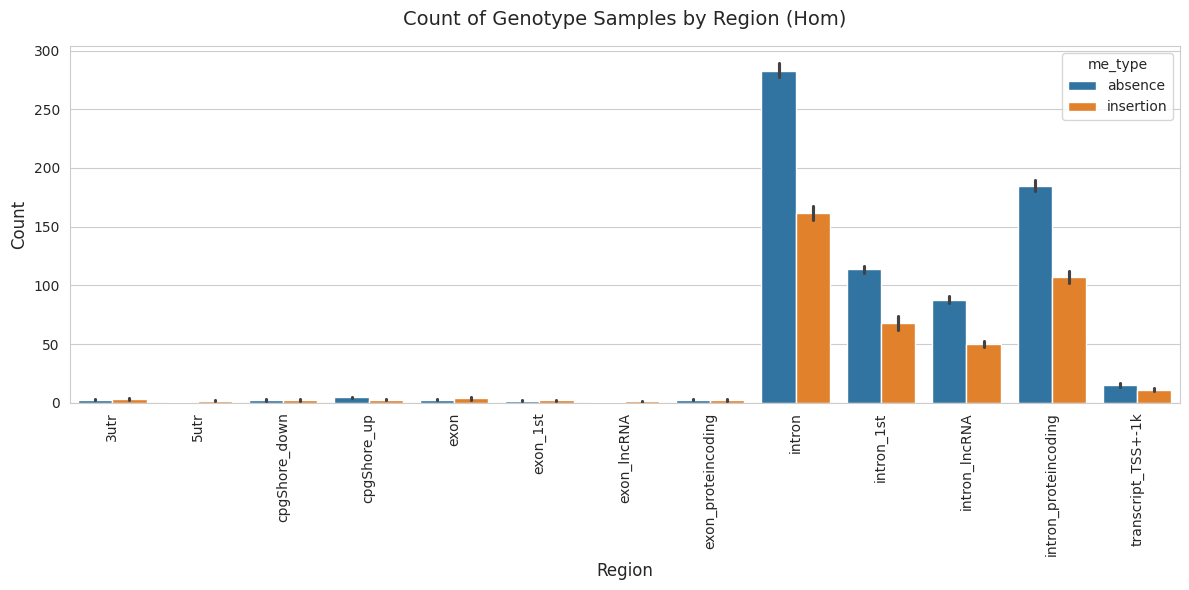

In [301]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot DataFrame (from your example)
plot_df = pd.DataFrame(comb_int_df.groupby(['region', 'me_type', 'genotype_sample', 'sample', 'class']).count()['het'])
plot_df.rename(columns={'het': 'count'}, inplace=True)
plot_df.reset_index(inplace=True)

# Set plot size and style
plt.figure(figsize=(12, 6))  # Increase plot size (width, height)
sns.set_style("whitegrid")  # Use a clean aesthetic style

# Create the barplot
sns.barplot(
    data=plot_df[(plot_df['genotype_sample'] == 'hom') & (plot_df['class'] == 'alu')],
    x='region', y='count', hue='me_type'
)

# Rotate x-axis labels
plt.xticks(rotation=90)

# Add a title and axis labels for better visualization
plt.title('Count of Genotype Samples by Region (Hom)', fontsize=14, pad=15)
plt.xlabel('Region', fontsize=12)
plt.ylabel('Count', fontsize=12)

# Display the plot
plt.tight_layout()  # Ensure everything fits nicely in the figure
plt.show()


# Enrichment analysis

In [89]:
#load in shuffled enrichment
tot_df = pd.read_csv('/cndd3/dburrows/DATA/me_polymorphisms/analysis/shuffle_enrichment.csv', sep = '\t', index_col=0)

#combine empirical data
l1_out = pd.concat([l1_cgi_df[['region', 'me_type', 'genotype', 'insertion_category', 'het', 'hom', 'length']], 
                    l1_all_df[['region', 'me_type', 'genotype', 'insertion_category', 'het', 'hom', 'length']]])
alu_out = pd.concat([alu_cgi_df[['region', 'me_type', 'genotype', 'insertion_category', 'het', 'hom', 'length']], 
                    alu_all_df[['region', 'me_type', 'genotype', 'insertion_category', 'het', 'hom', 'length']]])
l1_out['class'] = 'l1'
alu_out['class'] = 'alu'
reg_names = np.append(all_df[3].unique(), cgi_df[3].unique())


In [90]:
#combined
#===========
l1_ = pd.DataFrame(l1_out.groupby(['region']).count()['me_type'])
l1_ = l1_.reindex(reg_names, fill_value=0).reset_index()
l1_['class'] = 'l1'
alu_ = pd.DataFrame(alu_out.groupby(['region']).count()['me_type'])
alu_ = alu_.reindex(reg_names, fill_value=0).reset_index()
alu_['class'] = 'alu'
enr_df = pd.concat([l1_, alu_])
enr_df.rename(columns={'me_type':'count'}, inplace=True)


stat_region, stat_sig, stat_fc, stat_class = [],[],[],[]
for i in ['alu', 'l1']:
    if i == 'alu': total_observed = len(alu_df)
    if i == 'l1': total_observed = len(l1_df)
    for reg in reg_names:
        observed_overlap = enr_df[(enr_df['region' ]== reg) & (enr_df['class'] == i)]['count'].values[0]
        expected_overlap = np.mean(tot_df[(tot_df['region' ]== reg) & (tot_df['class'] == i)].groupby(['iteration']).count()['region'])
        from scipy.stats import fisher_exact
        no_overlap_observed = total_observed - observed_overlap
        no_overlap_expected = total_observed - expected_overlap
        # Contingency table
        contingency_table = [
            [observed_overlap, no_overlap_observed],  # Observed
            [expected_overlap, no_overlap_expected]  # Expected
        ]
        # Fisher's Exact Test
        odds_ratio, p_value = fisher_exact(contingency_table, alternative='two-sided')
        stat_region.append(reg)
        stat_class.append(i)
        stat_sig.append(p_value)
        stat_fc.append(np.log2(observed_overlap/expected_overlap))

/tmp/ipykernel_1364862/1026952381.py:33: RuntimeWarning: divide by zero encountered in log2
  stat_fc.append(np.log2(observed_overlap/expected_overlap))
/tmp/ipykernel_1364862/1026952381.py:33: RuntimeWarning: divide by zero encountered in log2
  stat_fc.append(np.log2(observed_overlap/expected_overlap))


/tmp/ipykernel_1364862/300766074.py:25: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  annotations = heatmap_fdr_data.applymap(lambda x: '*' if x < 0.05 else '')


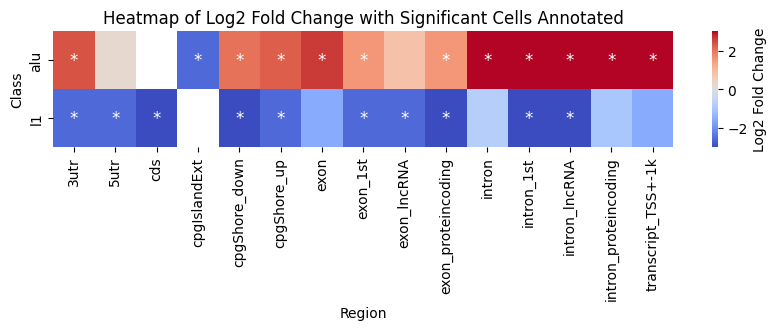

In [91]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.multitest import multipletests
import numpy as np

# Example data
data = pd.DataFrame({
    'stat_region': stat_region,
    'stat_class': stat_class,
    'stat_fc': stat_fc,
    'stat_pvalue': stat_sig
})

# Step 1: Apply FDR Correction
# Perform FDR correction
rejected, fdr_corrected_pvalues, _, _ = multipletests(data['stat_pvalue'], method='fdr_bh')
data['stat_fdr'] = fdr_corrected_pvalues  # Add FDR corrected p-values to the DataFrame

# Step 2: Pivot the DataFrame for Fold Change Heatmap
heatmap_fc_data = data.pivot(index='stat_class', columns='stat_region', values='stat_fc')
heatmap_fdr_data = data.pivot(index='stat_class', columns='stat_region', values='stat_fdr')

# Step 3: Create Annotation Matrix with Asterisks for Significant Cells
annotations = heatmap_fdr_data.applymap(lambda x: '*' if x < 0.05 else '')

# Step 4: Plot Heatmap with Asterisks
plt.figure(figsize=(10, 1.5))
sns.heatmap(
    heatmap_fc_data,
    annot=annotations,  # Add asterisks for significant cells
    fmt='',  # Prevent formatting issues
    cmap='coolwarm',
    cbar_kws={'label': 'Log2 Fold Change'},
    annot_kws={"fontsize": 12, "color": "white"},# Style for annotations
    vmin = -3, vmax = 3
)
plt.title('Heatmap of Log2 Fold Change with Significant Cells Annotated')
plt.ylabel('Class')
plt.xlabel('Region')
plt.show()


In [92]:
#insertion + absence
#===========
l1_ = pd.concat([pd.DataFrame(l1_out[l1_out['me_type'] == 'insertion'].groupby(['region']).count()['hom']).reindex(reg_names, fill_value=0).reset_index(),
                 pd.DataFrame(l1_out[l1_out['me_type'] == 'absence'].groupby(['region']).count()['hom']).reindex(reg_names, fill_value=0).reset_index()])
l1_['me_type'] = np.append( np.repeat('insertion', len(reg_names)), np.repeat('absence', len(reg_names))  )
l1_['class'] = 'l1'
alu_ = pd.concat([pd.DataFrame(alu_out[alu_out['me_type'] == 'insertion'].groupby(['region']).count()['hom']).reindex(reg_names, fill_value=0).reset_index(),
                 pd.DataFrame(alu_out[alu_out['me_type'] == 'absence'].groupby(['region']).count()['hom']).reindex(reg_names, fill_value=0).reset_index()])
alu_['me_type'] = np.append( np.repeat('insertion', len(reg_names)), np.repeat('absence', len(reg_names))  )
alu_['class'] = 'alu'
enr_df = pd.concat([l1_, alu_])
enr_df.rename(columns={'hom':'count'}, inplace=True)


stat_region, stat_sig, stat_fc, stat_class, stat_type = [],[],[],[],[]
for i in ['alu', 'l1']:
    if i == 'alu': total_observed = len(alu_df)
    if i == 'l1': total_observed = len(l1_df)
    for reg in reg_names:
        for typ in ['insertion', 'absence']:
            observed_overlap = enr_df[(enr_df['region' ]== reg) & (enr_df['class'] == i) & (enr_df['me_type'] == typ)]['count'].values[0]
            expected_overlap = np.mean(tot_df[(tot_df['region' ]== reg) & (tot_df['class'] == i) & (tot_df['me_type']==typ)].groupby(['iteration']).count()['region'])
            from scipy.stats import fisher_exact
            no_overlap_observed = total_observed - observed_overlap
            no_overlap_expected = total_observed - expected_overlap
            # Contingency table
            contingency_table = [
                [observed_overlap, no_overlap_observed],  # Observed
                [expected_overlap, no_overlap_expected]  # Expected
            ]
            # Fisher's Exact Test
            odds_ratio, p_value = fisher_exact(contingency_table, alternative='two-sided')
            stat_region.append(reg)
            stat_class.append(i + '_' +  typ)
            stat_sig.append(p_value)
            stat_fc.append(np.log2(observed_overlap/expected_overlap))

/tmp/ipykernel_1364862/3075990427.py:36: RuntimeWarning: divide by zero encountered in log2
  stat_fc.append(np.log2(observed_overlap/expected_overlap))
/tmp/ipykernel_1364862/3075990427.py:36: RuntimeWarning: divide by zero encountered in log2
  stat_fc.append(np.log2(observed_overlap/expected_overlap))
/tmp/ipykernel_1364862/3075990427.py:36: RuntimeWarning: divide by zero encountered in log2
  stat_fc.append(np.log2(observed_overlap/expected_overlap))
/tmp/ipykernel_1364862/3075990427.py:36: RuntimeWarning: divide by zero encountered in log2
  stat_fc.append(np.log2(observed_overlap/expected_overlap))
/tmp/ipykernel_1364862/3075990427.py:36: RuntimeWarning: divide by zero encountered in log2
  stat_fc.append(np.log2(observed_overlap/expected_overlap))
/tmp/ipykernel_1364862/3075990427.py:36: RuntimeWarning: divide by zero encountered in log2
  stat_fc.append(np.log2(observed_overlap/expected_overlap))
/tmp/ipykernel_1364862/3075990427.py:36: RuntimeWarning: divide by zero encountere

/tmp/ipykernel_1364862/3205949442.py:25: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  annotations = heatmap_fdr_data.applymap(lambda x: '*' if x < 0.05 else '')


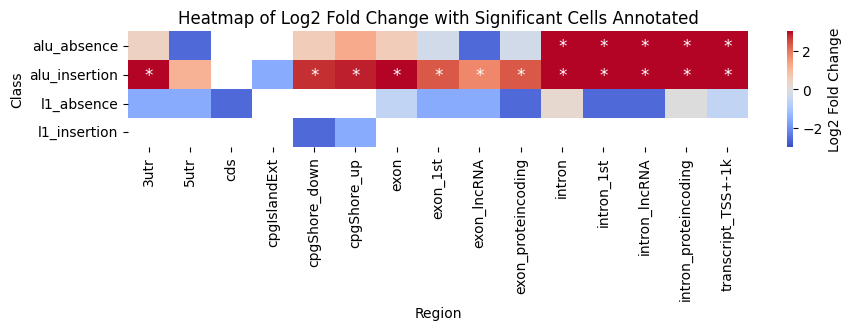

In [93]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.multitest import multipletests
import numpy as np

# Example data
data = pd.DataFrame({
    'stat_region': stat_region,
    'stat_class': stat_class,
    'stat_fc': stat_fc,
    'stat_pvalue': stat_sig
})

# Step 1: Apply FDR Correction
# Perform FDR correction
rejected, fdr_corrected_pvalues, _, _ = multipletests(data['stat_pvalue'], method='fdr_bh')
data['stat_fdr'] = fdr_corrected_pvalues  # Add FDR corrected p-values to the DataFrame

# Step 2: Pivot the DataFrame for Fold Change Heatmap
heatmap_fc_data = data.pivot(index='stat_class', columns='stat_region', values='stat_fc')
heatmap_fdr_data = data.pivot(index='stat_class', columns='stat_region', values='stat_fdr')

# Step 3: Create Annotation Matrix with Asterisks for Significant Cells
annotations = heatmap_fdr_data.applymap(lambda x: '*' if x < 0.05 else '')

# Step 4: Plot Heatmap with Asterisks
plt.figure(figsize=(10, 1.5))
sns.heatmap(
    heatmap_fc_data,
    annot=annotations,  # Add asterisks for significant cells
    fmt='',  # Prevent formatting issues
    cmap='coolwarm',
    cbar_kws={'label': 'Log2 Fold Change'},
    annot_kws={"fontsize": 12, "color": "white"},# Style for annotations
    vmin = -3, vmax = 3
)
plt.title('Heatmap of Log2 Fold Change with Significant Cells Annotated')
plt.ylabel('Class')
plt.xlabel('Region')
plt.show()

In [94]:
#het +  hom
#===========
l1_ = pd.concat([pd.DataFrame(l1_out[l1_out['genotype'] == 'het'].groupby(['region']).count()['hom']).reindex(reg_names, fill_value=0).reset_index(),
                 pd.DataFrame(l1_out[l1_out['genotype'] == 'hom'].groupby(['region']).count()['hom']).reindex(reg_names, fill_value=0).reset_index()])
l1_['genotype'] = np.append( np.repeat('het', len(reg_names)), np.repeat('hom', len(reg_names))  )
l1_['class'] = 'l1'
alu_ = pd.concat([pd.DataFrame(alu_out[alu_out['genotype'] == 'het'].groupby(['region']).count()['hom']).reindex(reg_names, fill_value=0).reset_index(),
                 pd.DataFrame(alu_out[alu_out['genotype'] == 'hom'].groupby(['region']).count()['hom']).reindex(reg_names, fill_value=0).reset_index()])
alu_['genotype'] = np.append( np.repeat('het', len(reg_names)), np.repeat('hom', len(reg_names))  )
alu_['class'] = 'alu'
enr_df = pd.concat([l1_, alu_])
enr_df.rename(columns={'hom':'count'}, inplace=True)


stat_region, stat_sig, stat_fc, stat_class, stat_type = [],[],[],[],[]
for i in ['alu', 'l1']:
    if i == 'alu': total_observed = len(alu_df)
    if i == 'l1': total_observed = len(l1_df)
    for reg in reg_names:
        for typ in ['het', 'hom']:
            observed_overlap = enr_df[(enr_df['region' ]== reg) & (enr_df['class'] == i) & (enr_df['genotype'] == typ)]['count'].values[0]
            expected_overlap = np.mean(tot_df[(tot_df['region' ]== reg) & (tot_df['class'] == i) & (tot_df['genotype']==typ)].groupby(['iteration']).count()['region'])
            from scipy.stats import fisher_exact
            no_overlap_observed = total_observed - observed_overlap
            no_overlap_expected = total_observed - expected_overlap
            # Contingency table
            contingency_table = [
                [observed_overlap, no_overlap_observed],  # Observed
                [expected_overlap, no_overlap_expected]  # Expected
            ]
            # Fisher's Exact Test
            odds_ratio, p_value = fisher_exact(contingency_table, alternative='two-sided')
            stat_region.append(reg)
            stat_class.append(i + '_' +  typ)
            stat_sig.append(p_value)
            stat_fc.append(np.log2(observed_overlap/expected_overlap))

/tmp/ipykernel_1364862/2694610045.py:36: RuntimeWarning: divide by zero encountered in log2
  stat_fc.append(np.log2(observed_overlap/expected_overlap))
/tmp/ipykernel_1364862/2694610045.py:36: RuntimeWarning: divide by zero encountered in log2
  stat_fc.append(np.log2(observed_overlap/expected_overlap))
/tmp/ipykernel_1364862/2694610045.py:36: RuntimeWarning: divide by zero encountered in log2
  stat_fc.append(np.log2(observed_overlap/expected_overlap))
/tmp/ipykernel_1364862/2694610045.py:36: RuntimeWarning: divide by zero encountered in log2
  stat_fc.append(np.log2(observed_overlap/expected_overlap))
/tmp/ipykernel_1364862/2694610045.py:36: RuntimeWarning: divide by zero encountered in log2
  stat_fc.append(np.log2(observed_overlap/expected_overlap))
/tmp/ipykernel_1364862/2694610045.py:36: RuntimeWarning: divide by zero encountered in log2
  stat_fc.append(np.log2(observed_overlap/expected_overlap))
/tmp/ipykernel_1364862/2694610045.py:36: RuntimeWarning: divide by zero encountere

/tmp/ipykernel_1364862/3205949442.py:25: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  annotations = heatmap_fdr_data.applymap(lambda x: '*' if x < 0.05 else '')


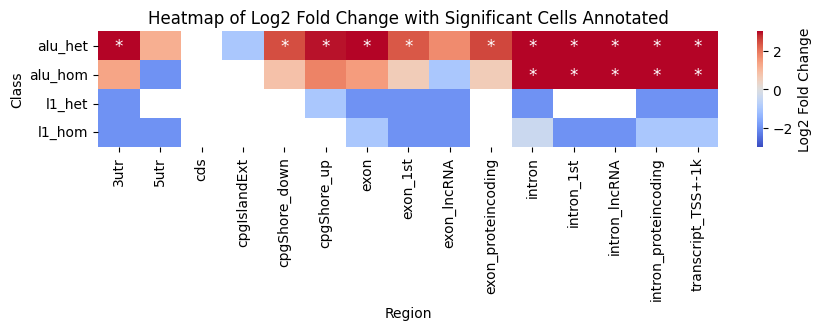

In [95]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.multitest import multipletests
import numpy as np

# Example data
data = pd.DataFrame({
    'stat_region': stat_region,
    'stat_class': stat_class,
    'stat_fc': stat_fc,
    'stat_pvalue': stat_sig
})

# Step 1: Apply FDR Correction
# Perform FDR correction
rejected, fdr_corrected_pvalues, _, _ = multipletests(data['stat_pvalue'], method='fdr_bh')
data['stat_fdr'] = fdr_corrected_pvalues  # Add FDR corrected p-values to the DataFrame

# Step 2: Pivot the DataFrame for Fold Change Heatmap
heatmap_fc_data = data.pivot(index='stat_class', columns='stat_region', values='stat_fc')
heatmap_fdr_data = data.pivot(index='stat_class', columns='stat_region', values='stat_fdr')

# Step 3: Create Annotation Matrix with Asterisks for Significant Cells
annotations = heatmap_fdr_data.applymap(lambda x: '*' if x < 0.05 else '')

# Step 4: Plot Heatmap with Asterisks
plt.figure(figsize=(10, 1.5))
sns.heatmap(
    heatmap_fc_data,
    annot=annotations,  # Add asterisks for significant cells
    fmt='',  # Prevent formatting issues
    cmap='coolwarm',
    cbar_kws={'label': 'Log2 Fold Change'},
    annot_kws={"fontsize": 12, "color": "white"},# Style for annotations
    vmin = -3, vmax = 3
)
plt.title('Heatmap of Log2 Fold Change with Significant Cells Annotated')
plt.ylabel('Class')
plt.xlabel('Region')
plt.show()

In [96]:
#truncated vs full length
#===========================
l1_ = pd.concat([pd.DataFrame(l1_out[l1_out['insertion_category'] == 'full_length'].groupby(['region']).count()['hom']).reindex(reg_names, fill_value=0).reset_index(),
                 pd.DataFrame(l1_out[l1_out['insertion_category'] == 'truncated'].groupby(['region']).count()['hom']).reindex(reg_names, fill_value=0).reset_index()])
l1_['insertion_category'] = np.append( np.repeat('full_length', len(reg_names)), np.repeat('truncated', len(reg_names))  )
l1_['class'] = 'l1'
alu_ = pd.concat([pd.DataFrame(alu_out[alu_out['insertion_category'] == 'full_length'].groupby(['region']).count()['hom']).reindex(reg_names, fill_value=0).reset_index(),
                 pd.DataFrame(alu_out[alu_out['insertion_category'] == 'truncated'].groupby(['region']).count()['hom']).reindex(reg_names, fill_value=0).reset_index()])
alu_['insertion_category'] = np.append( np.repeat('full_length', len(reg_names)), np.repeat('truncated', len(reg_names))  )
alu_['class'] = 'alu'
enr_df = pd.concat([l1_, alu_])
enr_df.rename(columns={'hom':'count'}, inplace=True)


stat_region, stat_sig, stat_fc, stat_class, stat_type = [],[],[],[],[]
for i in ['alu', 'l1']:
    if i == 'alu': total_observed = len(alu_df)
    if i == 'l1': total_observed = len(l1_df)
    for reg in reg_names:
        for typ in ['full_length', 'truncated']:
            observed_overlap = enr_df[(enr_df['region' ]== reg) & (enr_df['class'] == i) & (enr_df['insertion_category'] == typ)]['count'].values[0]
            expected_overlap = np.mean(tot_df[(tot_df['region' ]== reg) & (tot_df['class'] == i) & (tot_df['length']==typ)].groupby(['iteration']).count()['region'])
            from scipy.stats import fisher_exact
            no_overlap_observed = total_observed - observed_overlap
            no_overlap_expected = total_observed - expected_overlap
            # Contingency table
            contingency_table = [
                [observed_overlap, no_overlap_observed],  # Observed
                [expected_overlap, no_overlap_expected]  # Expected
            ]
            # Fisher's Exact Test
            odds_ratio, p_value = fisher_exact(contingency_table, alternative='two-sided')
            stat_region.append(reg)
            stat_class.append(i + '_' +  typ)
            stat_sig.append(p_value)
            stat_fc.append(np.log2(observed_overlap/expected_overlap))

/tmp/ipykernel_1364862/1378096900.py:36: RuntimeWarning: divide by zero encountered in log2
  stat_fc.append(np.log2(observed_overlap/expected_overlap))
/tmp/ipykernel_1364862/1378096900.py:36: RuntimeWarning: divide by zero encountered in log2
  stat_fc.append(np.log2(observed_overlap/expected_overlap))
/tmp/ipykernel_1364862/1378096900.py:36: RuntimeWarning: divide by zero encountered in log2
  stat_fc.append(np.log2(observed_overlap/expected_overlap))
/tmp/ipykernel_1364862/1378096900.py:36: RuntimeWarning: divide by zero encountered in log2
  stat_fc.append(np.log2(observed_overlap/expected_overlap))
/tmp/ipykernel_1364862/1378096900.py:36: RuntimeWarning: divide by zero encountered in log2
  stat_fc.append(np.log2(observed_overlap/expected_overlap))
/tmp/ipykernel_1364862/1378096900.py:36: RuntimeWarning: divide by zero encountered in log2
  stat_fc.append(np.log2(observed_overlap/expected_overlap))
/tmp/ipykernel_1364862/1378096900.py:36: RuntimeWarning: divide by zero encountere

/tmp/ipykernel_1012810/3205949442.py:25: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  annotations = heatmap_fdr_data.applymap(lambda x: '*' if x < 0.05 else '')


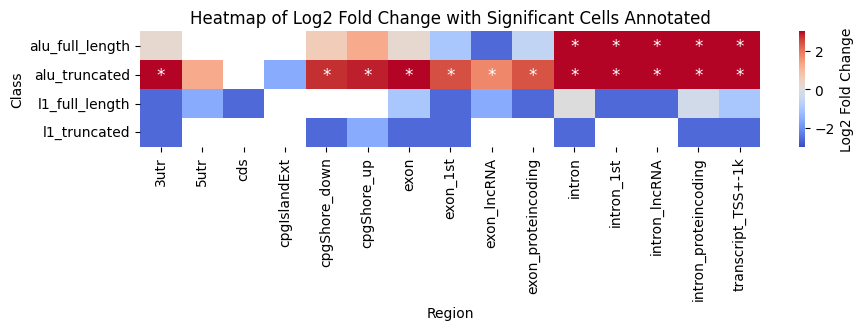

In [158]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.multitest import multipletests
import numpy as np

# Example data
data = pd.DataFrame({
    'stat_region': stat_region,
    'stat_class': stat_class,
    'stat_fc': stat_fc,
    'stat_pvalue': stat_sig
})

# Step 1: Apply FDR Correction
# Perform FDR correction
rejected, fdr_corrected_pvalues, _, _ = multipletests(data['stat_pvalue'], method='fdr_bh')
data['stat_fdr'] = fdr_corrected_pvalues  # Add FDR corrected p-values to the DataFrame

# Step 2: Pivot the DataFrame for Fold Change Heatmap
heatmap_fc_data = data.pivot(index='stat_class', columns='stat_region', values='stat_fc')
heatmap_fdr_data = data.pivot(index='stat_class', columns='stat_region', values='stat_fdr')

# Step 3: Create Annotation Matrix with Asterisks for Significant Cells
annotations = heatmap_fdr_data.applymap(lambda x: '*' if x < 0.05 else '')

# Step 4: Plot Heatmap with Asterisks
plt.figure(figsize=(10, 1.5))
sns.heatmap(
    heatmap_fc_data,
    annot=annotations,  # Add asterisks for significant cells
    fmt='',  # Prevent formatting issues
    cmap='coolwarm',
    cbar_kws={'label': 'Log2 Fold Change'},
    annot_kws={"fontsize": 12, "color": "white"},# Style for annotations
    vmin = -3, vmax = 3
)
plt.title('Heatmap of Log2 Fold Change with Significant Cells Annotated')
plt.ylabel('Class')
plt.xlabel('Region')
plt.show()

In [152]:
# run enrichment on reference elements
#load in reference elements
_alu = pd.read_csv('/home/AD/rkgadde/L1IP/mC_data/CZI/type/vars/non-polymorphic_refAlu.bed', sep='\t', header=None)
_alu_bt = pybedtools.BedTool.from_dataframe(_alu)
_l1 = pd.read_csv('/home/AD/rkgadde/L1IP/mC_data/CZI/type/vars/non-polymorphic_refL1.bed', sep='\t', header=None)
_l1_bt = pybedtools.BedTool.from_dataframe(_l1)

In [153]:
#check that theres no overlap with polymorphic
l1_prac = l1_bt.intersect(_l1_bt, f=0.9, wo=True) 
l1_prac = l1_prac.to_dataframe(disable_auto_names=True, header=None)

alu_prac = alu_bt.intersect(_alu_bt, f=0.9, wo=True) 
alu_prac = alu_prac.to_dataframe(disable_auto_names=True, header=None)

In [172]:
#compute intersection
_l1_cgi = _l1_bt.intersect(cgi_bt, f=0.3, wo=True) 
_alu_cgi = _alu_bt.intersect(cgi_bt, f=0.3, wo=True) 
_alu_all = _alu_bt.intersect(all_bt, f=0.3, wo=True) 
_l1_all = all_bt.intersect(_l1_bt, f=0.3, wo=True) 

_l1_cgi_df = _l1_cgi.to_dataframe(disable_auto_names=True, header=None)
_l1_cgi_df.rename(columns={10: 'region'}, inplace=True)
_l1_cgi_df['length'] = _l1_cgi_df[2] - _l1_cgi_df[1].values

_alu_cgi_df = _alu_cgi.to_dataframe(disable_auto_names=True, header=None)
_alu_cgi_df.rename(columns={10: 'region'}, inplace=True)
_alu_cgi_df['length'] = _alu_cgi_df[2] - _alu_cgi_df[1].values

_alu_all_df = _alu_all.to_dataframe(disable_auto_names=True, header=None)
_alu_all_df.rename(columns={10: 'region'}, inplace=True)
_alu_all_df['length'] = _alu_all_df[2] - _alu_all_df[1].values

_l1_all_df = _l1_all.to_dataframe(disable_auto_names=True, header=None)
_l1_all_df.rename(columns={3: 'region'}, inplace=True)
_l1_all_df['length'] = _l1_all_df[8] - _l1_all_df[7].values

In [210]:
#combine polymorphic data
l1_out = pd.concat([l1_cgi_df.groupby(['region']).count()[0], 
                    l1_all_df.groupby(['region']).count()[0]])
l1_out = l1_out.reindex(reg_names, fill_value=0).reset_index()
alu_out = pd.concat([alu_cgi_df.groupby(['region']).count()[0], 
                    alu_all_df.groupby(['region']).count()[0]])
alu_out = alu_out.reindex(reg_names, fill_value=0).reset_index()
l1_out['class'] = 'l1'
alu_out['class'] = 'alu'

ref_l1_out = pd.concat([_l1_cgi_df.groupby(['region']).count()[0], 
                    _l1_all_df.groupby(['region']).count()[0]])
ref_l1_out = ref_l1_out.reindex(reg_names, fill_value=0).reset_index()
ref_alu_out = pd.concat([_alu_cgi_df.groupby(['region']).count()[0], 
                    _alu_all_df.groupby(['region']).count()[0]])
ref_alu_out = ref_alu_out.reindex(reg_names, fill_value=0).reset_index()

ref_l1_out['class'] = 'l1'
ref_alu_out['class'] = 'alu'
enr_df = pd.concat([l1_out, alu_out, ref_l1_out, ref_alu_out])
enr_df['type'] = np.append(      np.repeat('polymorphic', len(l1_out) + len(alu_out)), 
                           np.repeat('non-polymorphic', len(ref_l1_out) + len(ref_alu_out))
)
enr_df.rename(columns={0:'count'}, inplace=True)

In [257]:
#combined
stat_region, stat_sig, stat_fc, stat_class, stat_type = [],[],[],[],[]
for i in ['alu', 'l1']:
    if i == 'alu': 
        total_poly = len(alu_df)
        total_nonpoly = len(_alu)
    if i == 'l1':
        total_poly = len(l1_df)
        total_nonpoly = len(_l1)
    for reg in reg_names:
        poly_overlap = enr_df[(enr_df['region' ]== reg) & (enr_df['class'] == i) & (enr_df['type'] == 'polymorphic')]['count'].values[0]
        nonpoly_overlap = enr_df[(enr_df['region' ]== reg) & (enr_df['class'] == i) & (enr_df['type'] == 'non-polymorphic')]['count'].values[0]
        from scipy.stats import fisher_exact
        poly_no_overlap = total_poly - poly_overlap
        nonpoly_no_overlap = total_nonpoly - nonpoly_overlap
        # Contingency table
        contingency_table = [
            [poly_overlap, poly_no_overlap],  # Observed
            [nonpoly_overlap, nonpoly_no_overlap]  # Expected
        ]
        # Fisher's Exact Test
        odds_ratio, p_value = fisher_exact(contingency_table, alternative='two-sided')
        stat_region.append(reg)
        stat_class.append(i)
        stat_sig.append(p_value)
        stat_fc.append(np.log2((poly_overlap/total_poly) / (nonpoly_overlap / total_nonpoly)))

/tmp/ipykernel_1364862/2701672943.py:26: RuntimeWarning: divide by zero encountered in log2
  stat_fc.append(np.log2((poly_overlap/total_poly) / (nonpoly_overlap / total_nonpoly)))


/tmp/ipykernel_1364862/962350160.py:25: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  annotations = heatmap_fdr_data.applymap(lambda x: '*' if x < 0.05 else '')


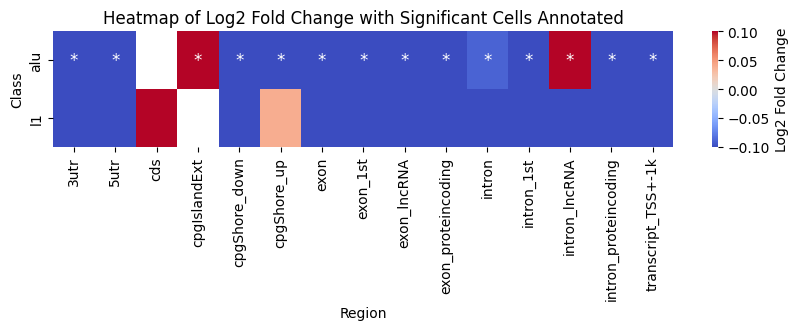

In [259]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.multitest import multipletests
import numpy as np

# Example data
data = pd.DataFrame({
    'stat_region': stat_region,
    'stat_class': stat_class,
    'stat_fc': stat_fc,
    'stat_pvalue': stat_sig,
})

# Step 1: Apply FDR Correction
# Perform FDR correction
rejected, fdr_corrected_pvalues, _, _ = multipletests(data['stat_pvalue'], method='fdr_bh')
data['stat_fdr'] = fdr_corrected_pvalues  # Add FDR corrected p-values to the DataFrame

# Step 2: Pivot the DataFrame for Fold Change Heatmap
heatmap_fc_data = data.pivot(index='stat_class', columns='stat_region', values='stat_fc')
heatmap_fdr_data = data.pivot(index='stat_class', columns='stat_region', values='stat_fdr')

# Step 3: Create Annotation Matrix with Asterisks for Significant Cells
annotations = heatmap_fdr_data.applymap(lambda x: '*' if x < 0.05 else '')

# Step 4: Plot Heatmap with Asterisks
plt.figure(figsize=(10, 1.5))
sns.heatmap(
    heatmap_fc_data,
    annot=annotations,  # Add asterisks for significant cells
    fmt='',  # Prevent formatting issues
    cmap='coolwarm',
    cbar_kws={'label': 'Log2 Fold Change'},
    annot_kws={"fontsize": 12, "color": "white"},# Style for annotations
)
plt.title('Heatmap of Log2 Fold Change with Significant Cells Annotated')
plt.ylabel('Class')
plt.xlabel('Region')
plt.show()